<a href="https://colab.research.google.com/github/Zoella-Choi/DataAnalysis/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_15%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15강 시계열 데이터 분석 : 주가 데이터 활용

### 목표

- S&P500 지수를 중심으로 주가 데이터를 수집
- 다양한 시계열 분석 기법을 적용하여 의미 있는 인사이트를 도출

> ⚠️**주의**⚠️ : 이번 장에서 다루는 내용은 순전히 교육 및 실습 목적으로 주가 데이터를 활용하는 것이며, 실제 투자 결정을 위한 가이드로 사용할 수 없다. 시계열 분석 기법은 과거 데이터의 패턴을 학습하는 데 유용하나, 금융 시장의 불확실성과 예측 불가능한 사건들로 인해 실제 투자에 적용할 경우 상당한 위험이 따를 수 있다. 어떤 분석 방법도 미래 주가를 완벽히 예측할 수 없으며, 본 내용은 데이터 분석 기술을 배우는 학습 도구로만 활용하길 권장한다.

### 분석 프로세스 개요

1. 데이터 수집
  - yfinance를 이용한 데이터 수집
  - 데이터 구조 이해
2. 금융 시계열 분석
  - 기술적 지표 계산 (이동평균, RSI)
  - 거래 신호 생성 및 거래 전략 구성
  - 백테스팅
3. Prophet 기반 예측
  - 단기 주가 예측 모델 학습 및 평가
4. GBRT 기반 예측
  - 특성 변수 설계 및 예측 모델 학습
  - 예측 기반 투자 전략 및 백테스팅

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (27.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and direc

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집

## 15-1 yfinance를 이용한 S&P 500 데이터 다운로드

In [4]:
# yfinance 임포트
import yfinance as yf
import datetime

symbol = 'S&P500'
ticker = '^GSPC'

## 데이터 수집 날짜 설정 (2014년 1월 1일) ~ (2019년 12월 31일)
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

## yfinance를 사용하여 S&P 500 (^GSPC) 데이터를 지정된 기간 동안 다운로드
df = yf.download(ticker, start=start_date, end=end_date)

## MultiIndex 컬럼에서 두 번째 레벨(보통 'Adj Close' 등)을 제거하여 컬럼 이름을 단순화
df.columns = df.columns.droplevel(1)

## 다운로드된 DataFrame의 기술 통계량 출력
df.describe()

/tmp/ipython-input-169319509.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,2365.076824,2374.893937,2353.617748,2364.783671,3.588534e+09
std,380.653792,381.515469,379.812445,380.702127,6.749905e+08
min,1741.890015,1755.790039,1737.920044,1743.819946,1.296530e+09
25%,2050.629883,2062.830078,2041.479980,2049.729980,3.201300e+09
50%,2265.179932,2271.780029,2258.409912,2266.810059,3.502190e+09
75%,2723.060059,2737.600098,2708.850098,2722.120117,3.875630e+09
max,3240.020020,3247.929932,3234.370117,3247.229980,7.657890e+09


## 15-2 S&P 500 데이터 시각화 (훈련/테스트 분할)

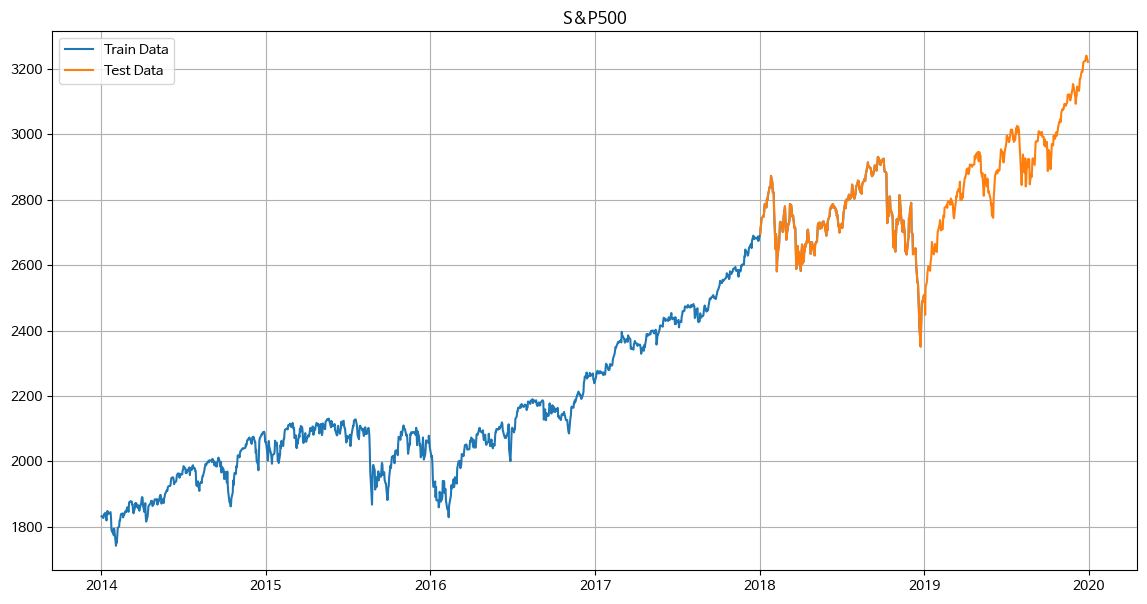

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.grid(True)
plt.title('S&P500')
## 2018년까지의 데이터를 훈련 데이터로 시각화
plt.plot(df[:'2018'].index, df[:'2018']['Close'], label='Train Data')
## 2018년 이후 데이터를 훈련 데이터로 시각화
plt.plot(df['2018':].index, df['2018':]['Close'], label='Test Data')
plt.legend()
plt.show()

# 2. 금융 시계열 분석

## 15-3 기술 지표 계산

In [6]:
## 50일 이동 평균 계산
df['MA50'] = df['Close'].rolling(window=50).mean()
## 200일 이동 평균 계산
df['MA200'] = df['Close'].rolling(window=200).mean()

## 일별 수익률 계산
df['Returns'] = df['Close'].pct_change()

## RSI 계산
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

## 15-4 기본 차트 생성 및 시각화

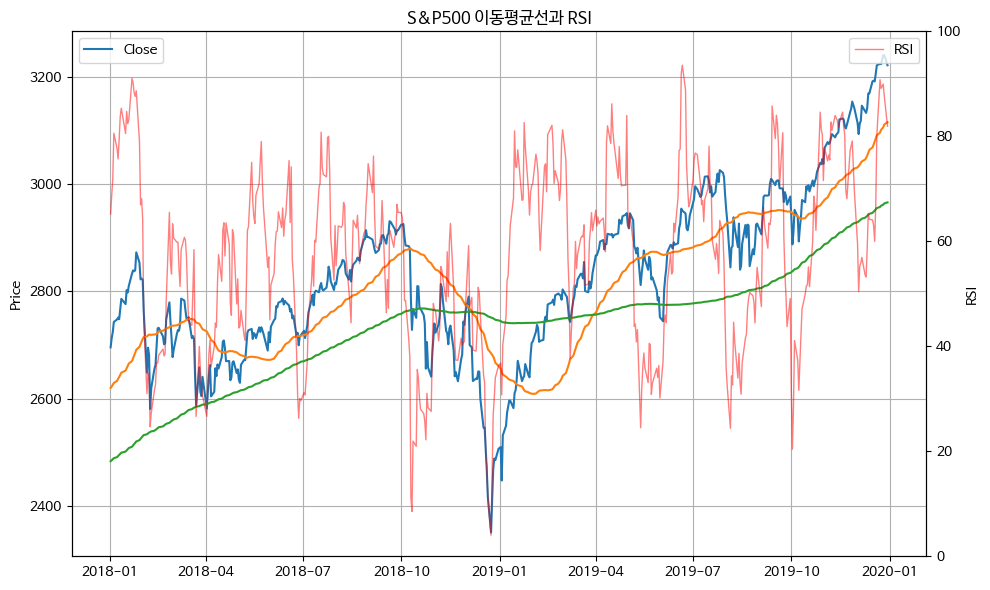

In [7]:
def make_base_chart(df, title, show_close_only=False):
  ## 기본 차트(종가, 이동평균선, RSI)를 생성하는 함수
  fig, ax1 = plt.subplots(figsize=(10, 6))

  ax1.plot(df.index, df['Close'], label='Close')
  ax1.set_title(title)
  ax1.set_ylabel('Price')
  ax1.grid(True)
  ax1.legend(loc='upper left')

  if not show_close_only:
    ## 종가만 표시하지 않을 경우
    ax2 = ax1.twinx()
    ax1.plot(df.index, df['MA50'], label='MA50')
    ax1.plot(df.index, df['MA200'], label='MA200')
    ax2.plot(df.index, df['RSI'], 'red', label='RSI', alpha=0.5, linewidth=1)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)  # RSI는 0-100 범위
    ax2.legend(loc='upper right')

  return fig, ax1

## 테스트 데이터셋 (2018년 이후)에 대해 기본 차트 시각화
test_df = df['2018':]
fig, ax1 = make_base_chart(test_df, 'S&P500 이동평균선과 RSI')
plt.tight_layout()
plt.show()

## 15-5 매수/매도 신호 생성

In [8]:
import pandas as pd

def make_signal(df):
  ## 이동평균선과 RSI를 기반으로 매수/매도 신호를 생성하는 함수
  buy = ( (test_df['MA50'] > test_df['MA200']) & (test_df['MA50'].shift(1) <= test_df['MA200'].shift(1)) |
         ## MA 골든 크로스 (현재 시점에서 50일 이동 평균이 200일 이동 평균보다 위에 있다. & 이전 시점에서는 50일 이동 평균이 200일 이동 평균보다 같거나 아래에 있었다.)
        (test_df['RSI'] > 30) & (test_df['RSI'].shift(1) <= 30)) ## RSI 30 상향 돌파


  sell = ( (test_df['MA50'] < test_df['MA200']) & (test_df['MA50'].shift(1) >= test_df['MA200'].shift(1)) | ## MA 데드 크로스 (현재 시점에서 50일 이동 평균이 200일 이동 평균보다 아래에 있다. & 이전 시점에서는 50일 이동 평균이 200일 이동 평균보다 같거나 위에 있었다.)
          (test_df['RSI'] < 70) & (test_df['RSI'].shift(1) >= 70)) ## RSI 70 하향 돌파

  return buy, sell

## 테스트 데이터셋에 대해 매수/매도 신호 생성
test_df = df['2018':].copy()
buy, sell = make_signal(test_df)

In [ ]:
sell

## 15-6 매수/매도 신호 시각화

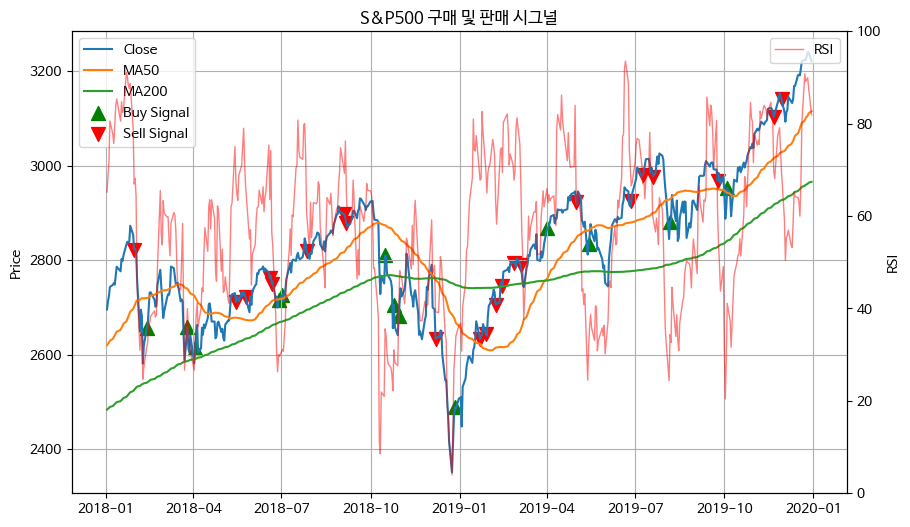

In [11]:
def plot_signal(df, buy, sell):
  ## 매수/매도 신호를 차트에 표시하는 함수
  fig, ax1 = make_base_chart(df, "S&P500 구매 및 판매 시그널") ## 기본 차트 생성

  ## 매수/매도 신호 날짜 추출
  buy_dates = df.index[buy]
  sell_dates = df.index[sell] ## 매도 신호 날짜 추출

  ## 매수/매도 신호 산점도로 표시
  ax1.scatter(buy_dates, df.loc[buy_dates, 'Close'], marker='^', color='g', s=100, label='Buy Signal')
  ax1.scatter(sell_dates, df.loc[sell_dates, 'Close'], marker='v', color='r', s=100, label='Sell Signal')

  # 범례 업데이트
  handles, labels = ax1.get_legend_handles_labels()
  ax1.legend(handles=handles, labels=labels, loc='upper left')

  return fig, ax1

fig, ax1 = plot_signal(test_df, buy, sell)
plt.show()

## 15-7 거래 포지션 생성 및 시각화

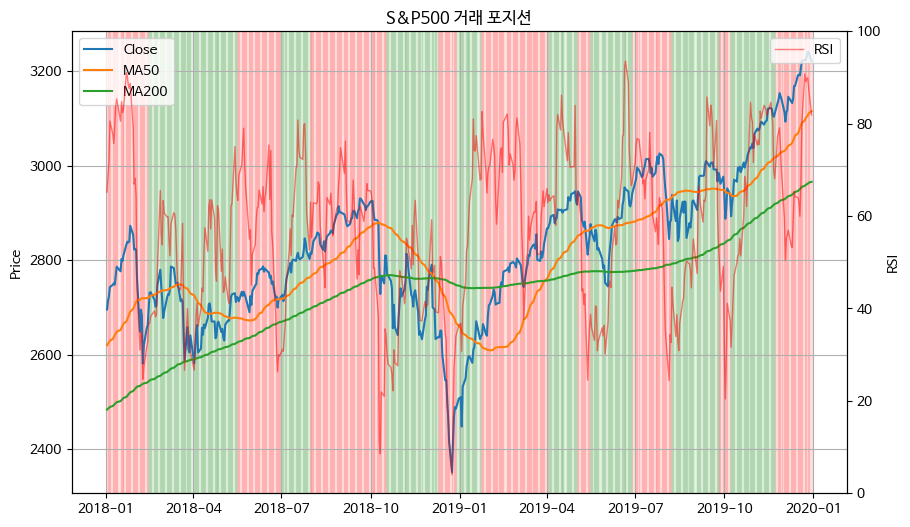

In [12]:
def make_and_plot_position(df, buy, sell):
    ## 거래 포지션(보유/미보유)을 생성하고 차트에 시각화하는 함수

    ## DataFrame 인덱스로 새로운 'position' DataFrame 생성
    position = pd.DataFrame(index=df.index)
    ## 매수 시 signal 1, 매도 시 signal 0 할당
    position.loc[buy, 'signal'] = 1
    position.loc[sell, 'signal'] = 0

    ## 신호를 하루 뒤로 밀어 포지션 시작 시점 반영
    position = position['signal'].shift(1)

    # 처음 상태는 0(미보유)로 시작
    position['position'] = position.ffill().fillna(0)

    ## 기본 차트 생성
    fig, ax1 = make_base_chart(df, 'S&P500 거래 포지션')

    for i in range(len(df)-1):
        ## 포지션이 1(보유)인 경우 초록색 음영 생성
        if position['position'].iloc[i] == 1:
            ax1.axvspan(df.index[i], df.index[i+1], alpha=0.1, color='green')
        ## 포지션이 0(미보유)인 경우 빨간색 음영 생성
        else:
            ax1.axvspan(df.index[i], df.index[i+1], alpha=0.1, color='red')

    # 범례 업데이트
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=labels, loc='upper left')

    return position

## 거래 포지션 생성 및 시각화
position = make_and_plot_position(test_df, buy, sell)

## 15-8 백테스트 및 수익률 분석

Buy & Hold 최종 수익률: 20.48%
전략 최종 수익률: 19.60%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


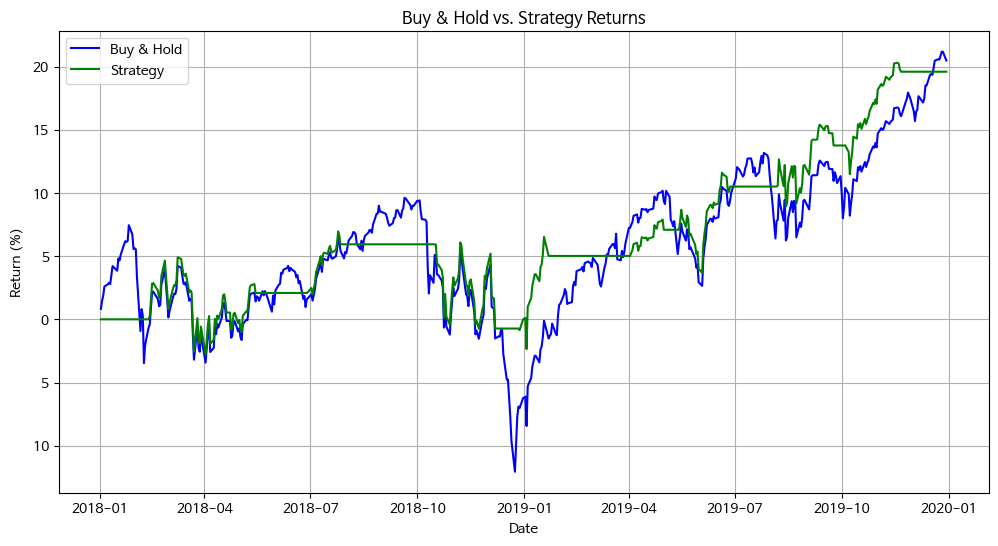

In [13]:
def backtest(df, position):
    ## 일별 수익률 사용 (이미 계산된 값)
    daily_returns = df['Returns']

    ## 1) Buy & Hold 전략의 누적 수익률
    buy_hold_returns = (1 + daily_returns).cumprod() - 1

    ## 2) 포지션에 따른 전략의 수익률
    strategy_returns = daily_returns * position['position']

    ## 누적 수익률 계산
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1

    final_buy_hold_return = buy_hold_returns.iloc[-1] * 100
    final_strategy_return = strategy_cumulative_returns.iloc[-1] * 100

    print(f"Buy & Hold 최종 수익률: {final_buy_hold_return:.2f}%")
    print(f"전략 최종 수익률: {final_strategy_return:.2f}%")

    ## 수익률 추이 그래프 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(buy_hold_returns.index, buy_hold_returns * 100, label='Buy & Hold', color='blue')
    plt.plot(strategy_cumulative_returns.index, strategy_cumulative_returns * 100, label='Strategy', color='green')
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.title('Buy & Hold vs. Strategy Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

backtest(test_df, position)

# 3. Prophet 기반 예측

## 15-9 Prophet 예측 및 시각화

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzenc6o5n/0e33ciyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzenc6o5n/zbp8dpj0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50862', 'data', 'file=/tmp/tmpzenc6o5n/0e33ciyz.json', 'init=/tmp/tmpzenc6o5n/zbp8dpj0.json', 'output', 'file=/tmp/tmpzenc6o5n/prophet_modelkzwe4xqe/prophet_model-20251018122706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


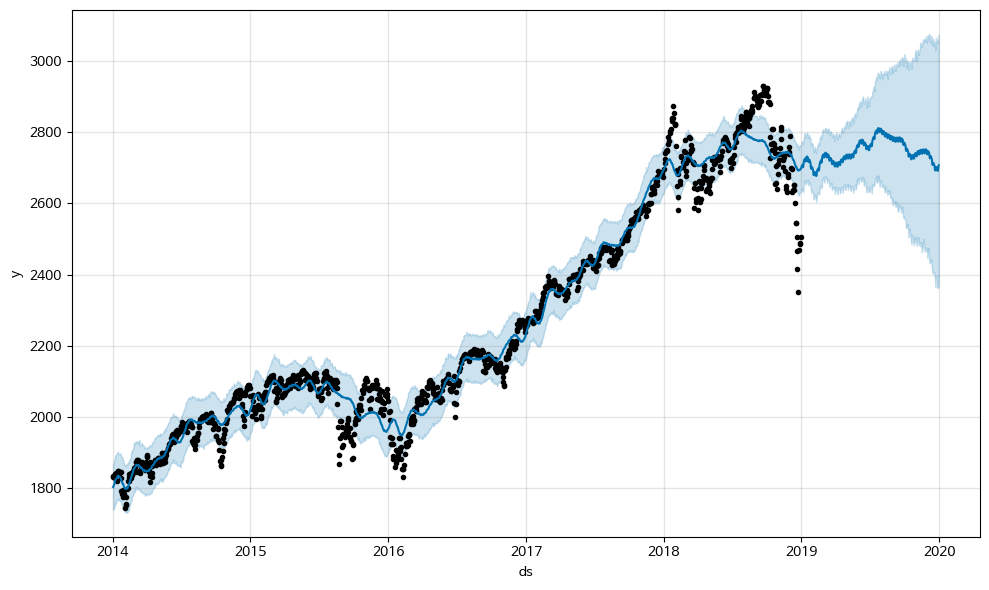

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:197: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


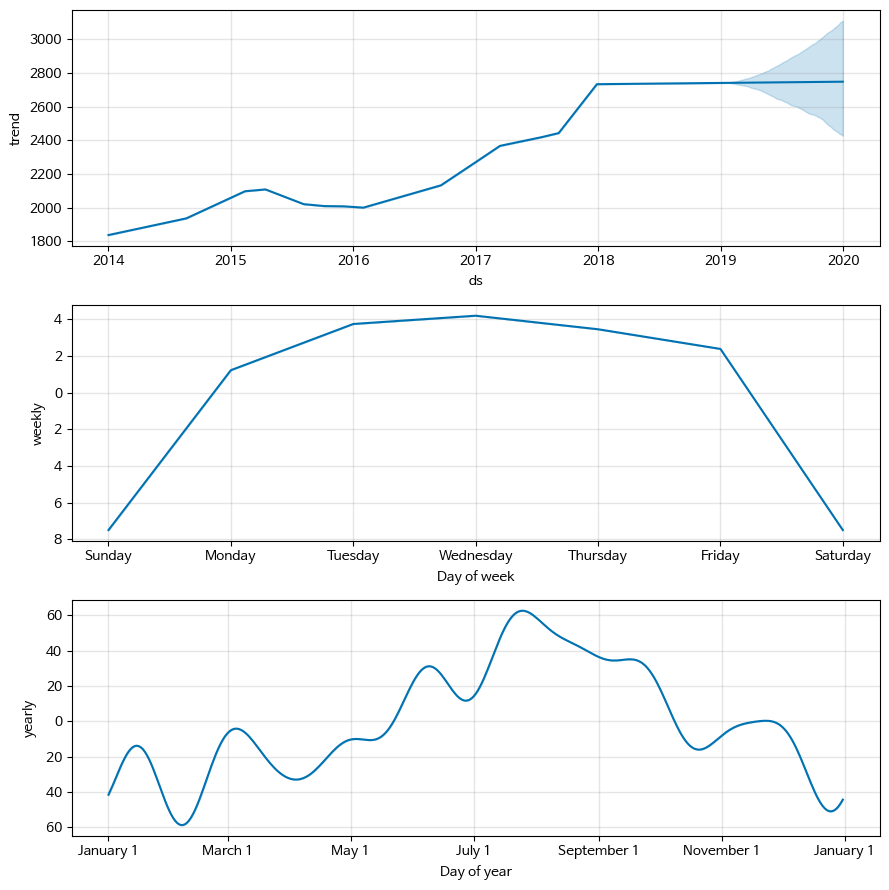

In [14]:
# prophet 모듈에서 Prophet 클래스 임포트
from prophet import Prophet

def prophet_prediction(df, periods=5):
    ## Prophet 모델을 사용하여 시계열 데이터를 예측하는 함수

    ## Prophet 형식에 맞게 DataFrame 준비
    # prophet은 ds와 y 칼럼 필요. df의 인덱스를 해제하고, Date와 Close 칼럼만 선택한 다음, Date를 ds로, Close를 y로 변환하여 prophet_df로 저장.
    prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

    ## Prophet 모델 훈련
    model = Prophet()
    model.fit(prophet_df)

    ## 미래 예측
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return model, forecast

## 훈련 데이터 셋 생성
train_df = df[:'2018']
## 훈련 데이터로 향후 365일 예측
model, forecast = prophet_prediction(train_df, periods=365)

## 예측 결과 및 시계열 구성 요소 시각화
fig1 = model.plot(forecast)
plt.show()
fig2 = model.plot_components(forecast)
plt.show()

## 15-10 확장 윈도우 예측

In [15]:
def expanding_window_forecast(train_df, test_df, step_size=30):
    ## 확장 윈도우 방식으로 Prophet 모델을 사용하여 예측을 수행하는 함수
    # 30일 간격으로 새로운 모델을 생성하고 예측
    result_df = test_df.copy()
    # prophet 결과 칼럼 추가
    for col in ['yhat', 'yhat_upper', 'yhat_lower']:
        result_df[col] = None

    current_train = train_df.copy()

    ## 테스트 데이터셋을 step_size 간격으로 순회
    for i in range(0, len(test_df), step_size):
        ## 테스트 기간 설정
        current_test = test_df.iloc[i:min(i + step_size, len(test_df))]
        ## 최근 365일 훈련 데이터로 Prophet 예측 수행
        _, forecast = prophet_prediction(current_train[-365:], periods=len(current_test))

        ## 예측 결과를 저장
        for j, date in enumerate(current_test.index):
            for col in ['yhat', 'yhat_upper', 'yhat_lower']:
                result_df.loc[date, col] = forecast.tail(len(current_test)).iloc[j][col]

        ## 훈련 데이터 셋 확장
        current_train = pd.concat([current_train, current_test])

    return result_df

## 확장 윈도우 예측 수행 (2018년까지 훈련, 2018년 이후 테스트)
prophet_df = df.copy()
prophet_prediction_df = expanding_window_forecast(prophet_df[:'2018'], prophet_df['2018':])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzenc6o5n/v6uu872p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzenc6o5n/uk1fixv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97', 'data', 'file=/tmp/tmpzenc6o5n/v6uu872p.json', 'init=/tmp/tmpzenc6o5n/uk1fixv0.json', 'output', 'file=/tmp/tmpzenc6o5n/prophet_model5idm7mwr/prophet_model-20251018123022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:30:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. 

In [16]:
prophet_prediction_df

Price,Close,High,Low,Open,Volume,MA50,MA200,Returns,RSI,yhat,yhat_upper,yhat_lower
Date,,,,,,,,,,,,
2018-01-02,2695.810059,2695.889893,2682.360107,2683.729980,3397430000,2620.087417,2483.772007,0.008303,65.198592,2527.260453,2575.102709,2475.55475
2018-01-03,2713.060059,2714.370117,2697.770020,2697.850098,3544030000,2622.844419,2485.469957,0.006399,68.687471,2522.296991,2574.403594,2466.072813
2018-01-04,2723.989990,2729.290039,2719.070068,2719.310059,3697340000,2626.024619,2487.369807,0.004029,71.736327,2518.944407,2572.563269,2466.356267
2018-01-05,2743.149902,2743.449951,2727.919922,2731.330078,3239280000,2629.505020,2489.343307,0.007034,80.592127,2514.59128,2567.549878,2463.158779
2018-01-08,2747.709961,2748.510010,2737.600098,2742.669922,3246160000,2633.316221,2491.352057,0.001662,77.713558,2521.984416,2574.389307,2470.394278
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,3224.010010,3227.780029,3222.300049,3226.050049,3064530000,3095.816587,2957.399591,0.000866,90.788893,3126.94775,3189.3274,3065.112161
2019-12-24,3223.379883,3226.429932,3220.510010,3225.449951,1296530000,3100.961187,2959.558890,-0.000195,89.110360,3128.486862,3188.22105,3064.245804
2019-12-26,3239.909912,3240.080078,3227.199951,3227.199951,2164540000,3105.845786,2961.703840,0.005128,89.952949,3110.535628,3171.796036,3040.854429


## 15-11 예측 결과 시각화

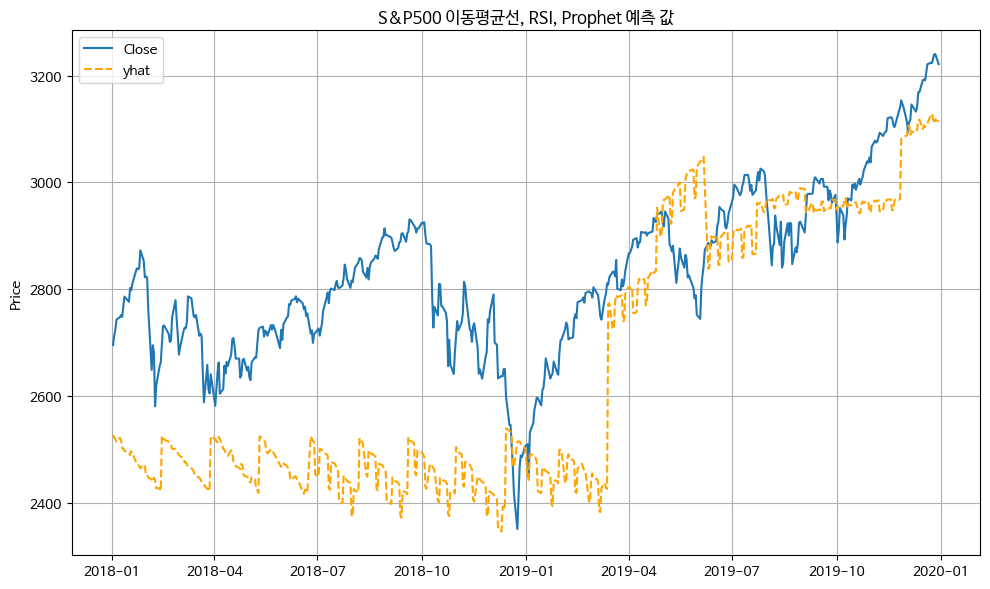

In [17]:
def plot_prediction(df_with_predictions, model='Prophet'):
    ## 예측 결과를 실제 종가와 함께 시각화하는 함수
    fig, ax1 = make_base_chart(df_with_predictions, f'S&P500 이동평균선, RSI, {model} 예측 값', show_close_only=True)
    ## 예측값(yhat) 플로팅
    ax1.plot(df_with_predictions.index, df_with_predictions['yhat'], label='yhat', color='orange', linestyle='--')
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=labels, loc='upper left')
    plt.tight_layout()
    plt.show()

plot_prediction(prophet_prediction_df, model='Prophet')

# 4. GBRT 기반 예측

## 15-12 Gradient Boosting Regressor 예측

In [18]:
# scikit learn의 ensemble 알고리즘 중 GradientBoostingRegresoor 임포트
from sklearn.ensemble import GradientBoostingRegressor

def expanding_window_forecast_gbrt(train_df, test_df, step_size=30):
    ## Gradient Boosting Regressor를 이용한 확장 윈도우 예측 함수

    ## 지연 피처 생성을 위한 훈련 및 테스트 데이터 결합
    combined = pd.concat([train_df, test_df])
    ## 피처 목록, (피처)_(지연일자)
    features = ['High_1', 'Low_1', 'Volume_1', 'MA50_1', 'MA200_1', 'Close_1', 'Close_2', 'Close_3', 'Close_4', 'Close_5', 'Close_6', 'Close_7']
    for feature in features:
        feature_column, lag = feature.split('_')  ## 피처 이름과 지연(lag) 분리
        combined[feature] = combined[feature_column].shift(int(lag))  ## 지연 피처 생성

    ## 학습 데이터, 훈련 데이터 재분리
    train = combined.loc[train_df.index]
    test = combined.loc[test_df.index]

    ## GBRT 모델 초기화
    # n_estimators=100, lr=0.1, max_depth=3, random_state=42로 설정
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                      max_depth=3, random_state=42)

    ## 예측 값 저장 칼럼 초기화
    test_df['yhat'] = None

    current_train = train.copy()
    ## 테스트 데이터셋을 step_size 간격으로 순회
    for start in range(0, len(test), step_size):
        ## 현재 테스트 윈도우 설정
        test_window = test.iloc[start:start+step_size]

        ## 최근 365일을 훈련 데이터로 설정
        train_data = current_train[-365:].dropna(subset=features + ['Close'])
        X_train, y_train = train_data[features], train_data['Close']

        ## 모델 학습
        model.fit(X_train, y_train)
        test_df.loc[test_window.index, 'yhat'] = model.predict(test_window[features])

        ## 훈련 데이터 확장
        current_train = pd.concat([current_train, test_window])

    return test_df

gbrt_df = df.copy()
## GBRT 확장 윈도우 예측 수행 (2018년까지 훈련, 2018년 이후 테스트)
gbrt_prediction_df = expanding_window_forecast_gbrt(gbrt_df[:'2018'], gbrt_df['2018':])

/tmp/ipython-input-3075775308.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['yhat'] = None


## 15-13 GBRT 예측 결과 시각화

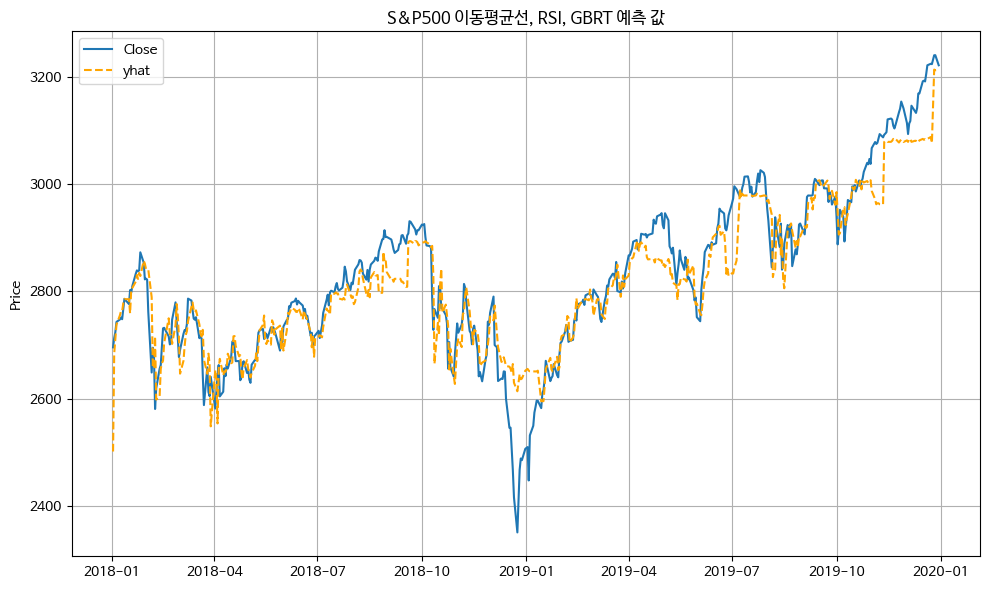

In [19]:
plot_prediction(gbrt_prediction_df, model='GBRT')

## 15-14 예측값을 활용한 매수/매도 신호 생성

In [20]:
def make_signal_with_prediction(df):
    buy = (
        (df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1)) |
        (df['RSI'] > 30) & (df['RSI'].shift(1) <= 30) |
        # 추가된 조건: 예측값이 현재 종가보다 높음 (상승 예측)
        (df['yhat'] > df['Close'] * 1.01)  # 1% 이상 상승 예측
    )

    sell = (
        (df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1)) |
        (df['RSI'] < 70) & (df['RSI'].shift(1) >= 70) |
        # 옵션: 예측값이 현재 종가보다 낮음 (하락 예측)
        (df['yhat'] < df['Close'] * 0.99)  # 1% 이상 하락 예측
    )

    return buy, sell

buy, sell = make_signal_with_prediction(gbrt_prediction_df)

## 15-15 예측값을 포함한 신호 시각화

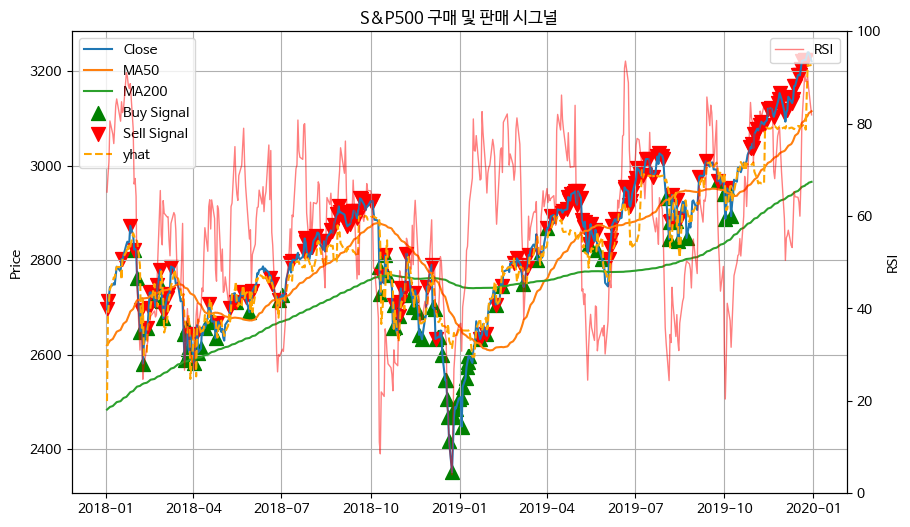

In [21]:
fig, ax1 = plot_signal(gbrt_prediction_df, buy, sell)
ax1.plot(gbrt_prediction_df.index, gbrt_prediction_df['yhat'], label='yhat', color='orange', linestyle='--')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=labels, loc='upper left')
plt.show()

## 15-16 예측 기반 거래 포지션 생성 및 시각화

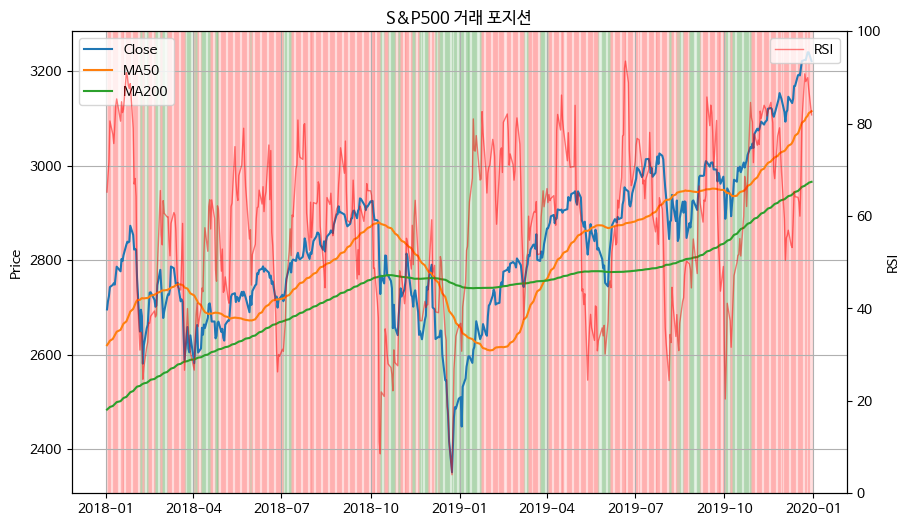

In [22]:
position = make_and_plot_position(gbrt_prediction_df, buy, sell)

## 15-17 예측 기반 전략 백테스트 실행

Buy & Hold 최종 수익률: 20.48%
전략 최종 수익률: 23.06%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


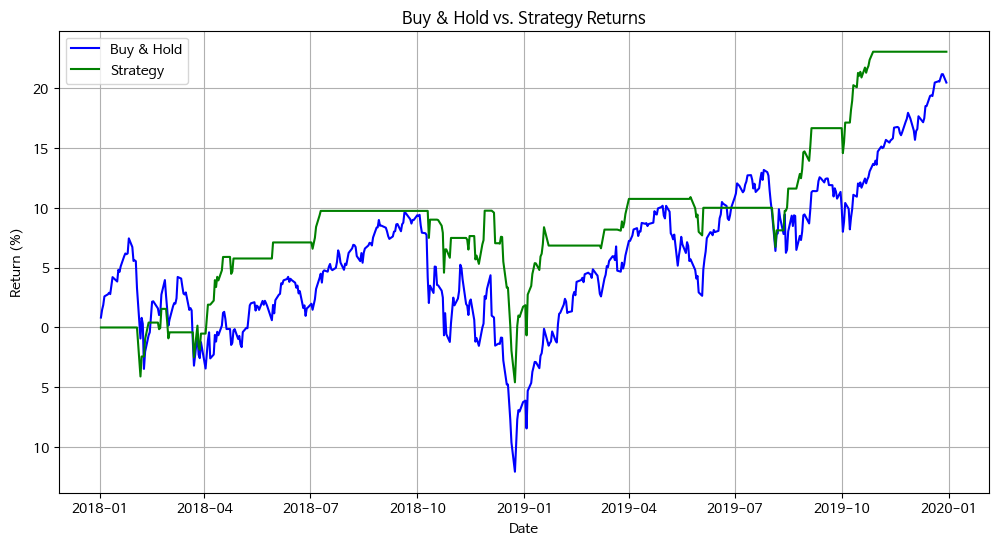

In [23]:
backtest(gbrt_prediction_df, position)